In [ ]:
import kagglehub
import os
import shutil
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import random
from IPython.display import Image,display
import glob
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, Input,Model
from PIL import Image
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, Add, ReLU, UpSampling2D
from keras.optimizers import Adam


In [ ]:
import zipfile


def unzip_file(zip_path, extract_to):
    """
    Dézippe un fichier .zip dans un dossier donné.

    Arguments :
    zip_path -- Chemin du fichier .zip à dézipper.
    extract_to -- Chemin du dossier où extraire les fichiers.
    """
    # Vérifiez si le fichier est un fichier ZIP valide
    if not zipfile.is_zipfile(zip_path):
        raise ValueError(f"{zip_path} n'est pas un fichier .zip valide")

    # Ouvrir le fichier ZIP
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Créer le dossier de destination s'il n'existe pas
        os.makedirs(extract_to, exist_ok=True)
        # Extraire tout le contenu
        zip_ref.extractall(extract_to)
        print(f"Fichiers extraits dans : {extract_to}")

# Exemple d'utilisation
zip_path = "/content/training_data_64_60k_Destroyed.zip"       # Remplacez par le chemin vers votre fichier ZIP
extract_to = "./"  # Remplacez par le dossier où vous voulez extraire
unzip_file(zip_path, extract_to)

Fichiers extraits dans : ./


In [ ]:

def create_image_dataframe(image_folder):
    """
    Creates a Pandas DataFrame from a folder of images, converting images to grayscale.

    Args:
        image_folder: The path to the folder containing the images.

    Returns:
        A Pandas DataFrame with columns 'image_name' and 'image'.
    """
    image_data = []
    for filename in os.listdir(image_folder):
        file_path = os.path.join(image_folder, filename)
        if os.path.isfile(file_path):
            try:
                # Read the image
                img = cv2.imread(file_path)
                if img is not None:
                    # Convert the image to grayscale
                    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    image_data.append([filename, gray_img])
            except Exception as e:
                print(f"Error reading image {filename}: {e}")
    return pd.DataFrame(image_data, columns=['image_name', 'image'])

In [ ]:
test_hr = create_image_dataframe("/content/test_hr")
test_lr = create_image_dataframe("/content/test_lr")
train_hr = create_image_dataframe("/content/train_hr")
train_lr = create_image_dataframe("/content/train_lr")
val_hr = create_image_dataframe("/content/val_hr")
val_lr = create_image_dataframe("/content/val_lr")

In [ ]:
print(len(train_hr), len(train_lr))
print(len(val_hr), len(val_lr))
print(len(test_hr), len(test_lr))
print(train_hr.columns)
print(train_hr.head())

55661 55661
11927 11927
11928 11928
Index(['image_name', 'image'], dtype='object')
         image_name                                              image
0    image42530.jpg  [[246, 246, 246, 246, 246, 246, 246, 246, 246,...
1    image73788.jpg  [[45, 66, 46, 32, 33, 52, 14, 47, 114, 151, 87...
2    image87627.jpg  [[172, 174, 174, 169, 160, 173, 167, 174, 166,...
3    image41840.jpg  [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
4  image122152.jpeg  [[235, 241, 246, 246, 242, 241, 241, 239, 237,...


In [ ]:

def verify_dataframe_coherence(df_hr, df_lr):
    """
    Verifies if two dataframes (high-resolution and low-resolution images) are coherent.

    Args:
        df_hr: Pandas DataFrame for high-resolution images.
        df_lr: Pandas DataFrame for low-resolution images.

    Returns:
        True if the dataframes are coherent, False otherwise.
        Prints details about discrepancies.
    """

    if df_hr.shape[0] != df_lr.shape[0]:
        print("Error: DataFrames have different numbers of rows.")
        print(f"HR DataFrame shape: {df_hr.shape}")
        print(f"LR DataFrame shape: {df_lr.shape}")
        return False

    hr_image_names = set(df_hr['image_name'])
    lr_image_names = set(df_lr['image_name'])

    if hr_image_names != lr_image_names:
        print("Error: Image names do not match.")
        print("HR Images not in LR:", hr_image_names - lr_image_names)
        print("LR Images not in HR:", lr_image_names - hr_image_names)

        return False

    return True

print(verify_dataframe_coherence(train_hr, train_lr))
print(verify_dataframe_coherence(val_hr, val_lr))
print(verify_dataframe_coherence(test_hr, test_lr))

True
True
True


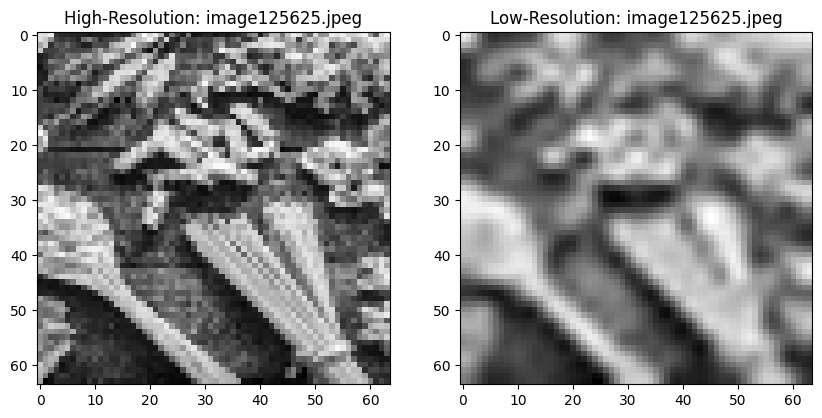

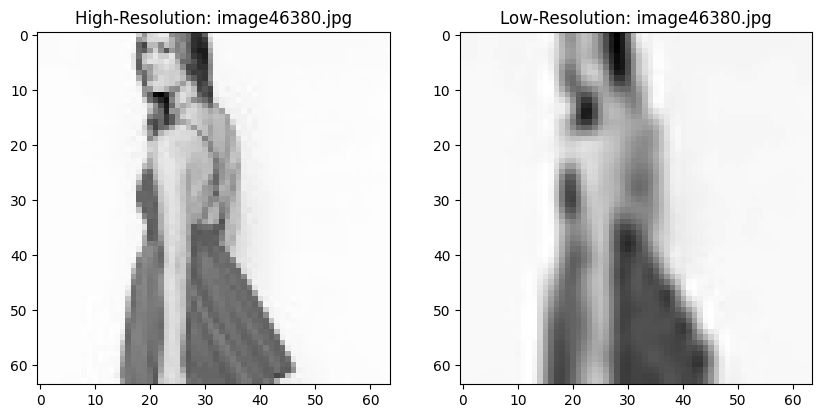

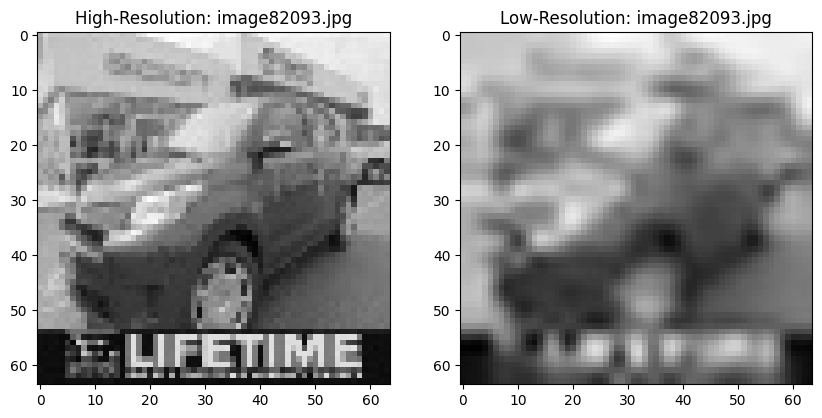

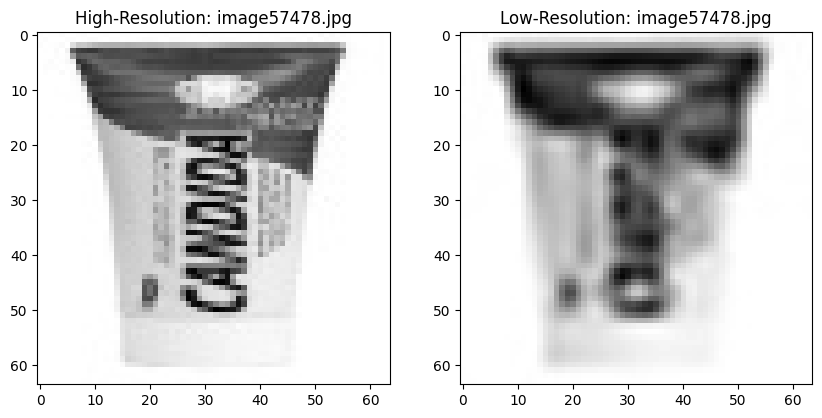

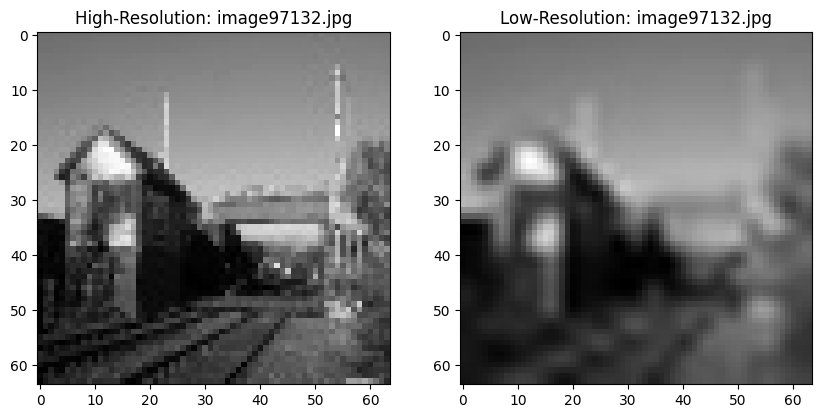

In [ ]:



def display_image_pairs(hr_df, lr_df, num_pairs=5):
    """Displays pairs of high-resolution and low-resolution images from dataframes."""

    if not verify_dataframe_coherence(hr_df, lr_df):
      print("DataFrames are not coherent. Cannot display image pairs.")
      return

    for i in range(min(num_pairs, len(hr_df))):
        image_name = hr_df['image_name'].iloc[i]
        hr_image = hr_df['image'].iloc[i]
        lr_image = lr_df['image'].iloc[i]

        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(hr_image, cmap='gray')
        axes[0].set_title(f"High-Resolution: {image_name}")
        axes[1].imshow(lr_image, cmap='gray')
        axes[1].set_title(f"Low-Resolution: {image_name}")
        plt.show()

# Example usage:
display_image_pairs(test_hr, test_lr)

In [ ]:

from keras.layers import Input, Conv2D, BatchNormalization



def build_srcnn_v2(input_shape=(None, None, 1)):
    """
    Crée un modèle SRCNN avec plus de couches et de filtres pour améliorer les performances.
    """
    # Entrée flexible pour des images de taille variable
    input_img = Input(shape=input_shape)

    # Première couche de convolution (extraction de caractéristiques)
    x = Conv2D(256, (7, 7), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)  # Normalisation par lots pour stabiliser l'entraînement

    # Deuxième couche de convolution (extraction de caractéristiques)
    x = Conv2D(64, (1, 1), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # Troisième couche de convolution (extraction de caractéristiques)
    x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # Quatrième couche de convolution (reconstruction de l'image)
    output = Conv2D(1, (5, 5), activation='sigmoid', padding='same')(x)  # Sortie en un seul canal (grayscale)

    # Créer le modèle
    model = Model(inputs=input_img, outputs=output)

    # Compilation du modèle avec un learning rate plus faible
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mae'])

    return model

# Définir le modèle avec une entrée flexible
srcnn_model = build_srcnn_v2(input_shape=(None, None, 1))

# Résumé du modèle
srcnn_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 1)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, None, None, 256)     │          12,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, None, None, 256)     │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, None, None, 64)      │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, None, None, 64)      │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, None, None, 64)      │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, None, None, 64)      │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, None, None, 1)       │           1,601 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,849 (526.75 KB)

 Trainable params: 134,081 (523.75 KB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:


def dataframe_to_tensor(df):
    """
    Convertit un DataFrame contenant des images en un tableau NumPy de forme (nombre_d'images, hauteur, largeur, 3).
    Normalise les images de 0 à 255 à 0 à 1.
    """
    # On suppose que df["images"] contient des objets de type ndarray, donc des images de forme (hauteur, largeur, 3)
    images = np.stack(df["image"].values)  # Convertir la colonne "images" en un tableau NumPy
    images = np.expand_dims(images, axis=-1)
    return images / 255.0  # Normalisation des images entre 0 et 1

# Préparer les datasets
train_lr = dataframe_to_tensor(train_lr)  # Images basses résolutions
train_hr = dataframe_to_tensor(train_hr)  # Images hautes résolutions

val_lr = dataframe_to_tensor(val_lr)
val_hr = dataframe_to_tensor(val_hr)



In [ ]:
# Vérifier la forme des images pour s'assurer qu'elles sont correctes
print("x_train shape:", train_lr.shape)  # Devrait être (nombre_images, hauteur, largeur)
print("y_train shape:", train_hr.shape)

x_train shape: (55661, 64, 64, 1)
y_train shape: (55661, 64, 64, 1)


In [ ]:

# Initialiser le callback ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',       # Surveille la perte de validation
    factor=0.5,               # Divise le learning rate par 2
    patience=4,               # Patience de 5 époques sans amélioration
    verbose=1,                # Affiche des messages de réduction du LR
    min_lr=1e-6               # Learning rate minimum (limite inférieure)
)

# Entraîner le modèle avec le callback
history = srcnn_model.fit(
    train_lr, train_hr,
    epochs=25,
    batch_size=64,
    validation_data=(val_lr, val_hr),
    callbacks=[reduce_lr]  # Ajoutez le callback ici
)

Epoch 1/25
870/870 ━━━━━━━━━━━━━━━━━━━━ 79s 77ms/step - loss: 0.0166 - mae: 0.0853 - val_loss: 0.0081 - val_mae: 0.0578 - learning_rate: 1.0000e-04
Epoch 2/25
870/870 ━━━━━━━━━━━━━━━━━━━━ 58s 66ms/step - loss: 0.0086 - mae: 0.0611 - val_loss: 0.0079 - val_mae: 0.0559 - learning_rate: 1.0000e-04
Epoch 3/25
870/870 ━━━━━━━━━━━━━━━━━━━━ 84s 69ms/step - loss: 0.0083 - mae: 0.0593 - val_loss: 0.0078 - val_mae: 0.0555 - learning_rate: 1.0000e-04
Epoch 4/25
870/870 ━━━━━━━━━━━━━━━━━━━━ 82s 69ms/step - loss: 0.0081 - mae: 0.0580 - val_loss: 0.0078 - val_mae: 0.0550 - learning_rate: 1.0000e-04
Epoch 5/25
870/870 ━━━━━━━━━━━━━━━━━━━━ 82s 69ms/step - loss: 0.0080 - mae: 0.0574 - val_loss: 0.0079 - val_mae: 0.0556 - learning_rate: 1.0000e-04
Epoch 6/25
870/870 ━━━━━━━━━━━━━━━━━━━━ 60s 69ms/step - loss: 0.0079 - mae: 0.0564 - val_loss: 0.0077 - val_mae: 0.0542 - learning_rate: 1.0000e-04
Epoch 7/25
870/870 ━━━━━━━━━━━━━━━━━━━━ 82s 69ms/step - loss: 0.0078 - mae: 0.0558 - val_loss: 0.0077 - val_mae:

In [ ]:

srcnn_model.save("./srcnn_model_64.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


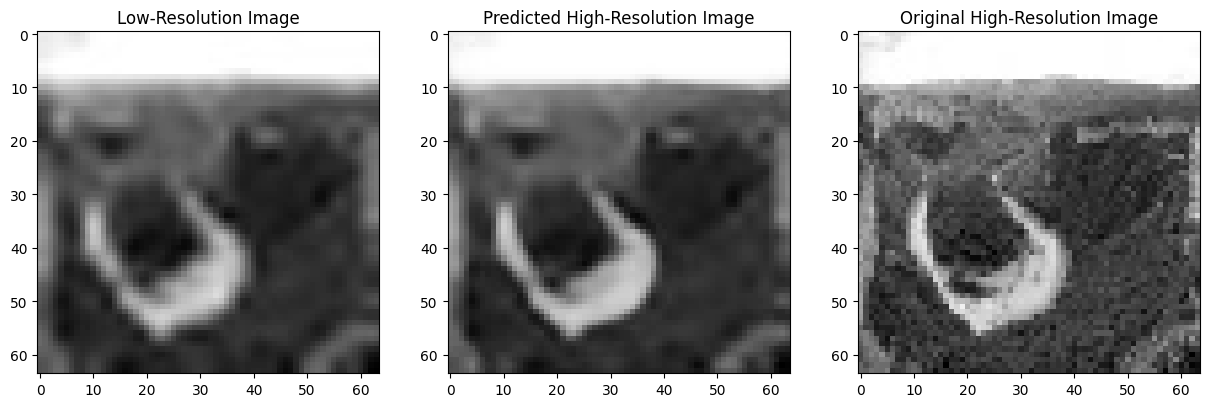

In [ ]:
from ast import Index
X_test = dataframe_to_tensor(test_lr)
y_test = dataframe_to_tensor(test_hr)

#test with one image
index = 21
test_image = X_test[index]
test_image = np.expand_dims(test_image, axis=0)

prediction = srcnn_model.predict(test_image)

#display the 3 images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(test_image[0], cmap='gray')
axes[0].set_title("Low-Resolution Image")
axes[1].imshow(prediction[0], cmap='gray')
axes[1].set_title("Predicted High-Resolution Image")
axes[2].imshow(y_test[index], cmap='gray')
axes[2].set_title("Original High-Resolution Image")
plt.show()

In [ ]:
from keras.models import load_model

# Charger le modèle
srcnn_model2 = load_model('./srcnn_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step


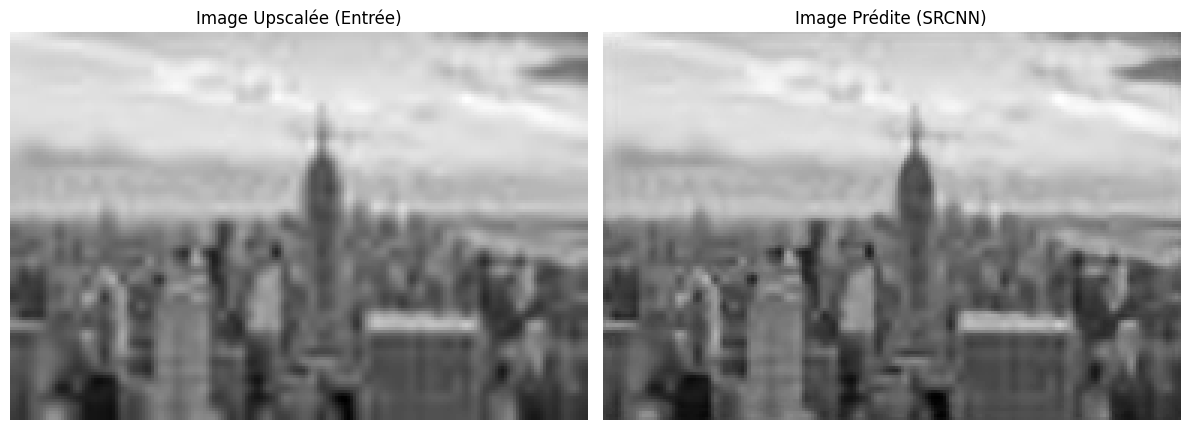

array([[227, 228, 227, ..., 115, 118, 112],
       [223, 224, 222, ..., 120, 118, 111],
       [216, 216, 216, ..., 129, 129, 121],
       ...,
       [ 68,  65,  66, ...,  59,  56,  53],
       [ 70,  62,  60, ...,  58,  55,  54],
       [ 70,  65,  61, ...,  58,  55,  58]], dtype=uint8)
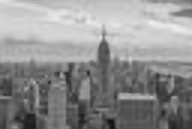

In [ ]:
import numpy as np
from PIL import Image
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt




def upscale_and_predict(model, image_path, scale_factor=3):
    """
    Upscale une image avec bicubic, prépare l'image pour le modèle SRCNN,
    affiche l'image originale (upscalée) et l'image prédite par le modèle.

    Args:
        model: Modèle SRCNN déjà entraîné.
        image_path: Chemin de l'image à prédire.
        scale_factor: Facteur d'agrandissement pour l'image.

    Returns:
        predicted_img: Image prédite sous forme de tableau numpy.
    """
    # Charger l'image
    img = Image.open(image_path).convert('L')  # Convertir en niveaux de gris (1 canal)

    # Upscale l'image avec interpolation bicubique
    new_size = (img.size[0] * scale_factor, img.size[1] * scale_factor)
    img_upscaled = img.resize(new_size, Image.BICUBIC)

    # Convertir l'image en tableau numpy, normaliser et ajouter les dimensions nécessaires
    img_array = img_to_array(img_upscaled)  # Shape: (H, W, 1)
    img_array = img_array / 255.0  # Normaliser entre 0 et 1
    img_array = np.expand_dims(img_array, axis=0)  # Ajouter dimension batch (1, H, W, 1)

    # Passer l'image dans le modèle pour obtenir la prédiction
    predicted_img = model.predict(img_array)

    # Retirer les dimensions inutiles
    predicted_img = np.squeeze(predicted_img, axis=0)  # Retirer batch dimension
    predicted_img = np.squeeze(predicted_img, axis=-1)  # Retirer canal supplémentaire

    # Convertir les valeurs prédictes en [0, 255]
    predicted_img = (predicted_img * 255).astype(np.uint8)

    # Afficher l'image originale (upscalée) et l'image prédite
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Afficher l'image upscalée (entrée du modèle)
    axes[0].imshow(np.squeeze(img_array[0]), cmap='gray')  # Retirer dimension batch pour afficher
    axes[0].set_title("Image Upscalée (Entrée)")
    axes[0].axis('off')

    # Afficher l'image prédite
    axes[1].imshow(predicted_img, cmap='gray')
    axes[1].set_title("Image Prédite (SRCNN)")
    axes[1].axis('off')

    # Montrer les deux images
    plt.tight_layout()
    plt.show()

    return predicted_img



upscale_and_predict(srcnn_model,"/content/testimage3.jpg")
